<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/%E2%80%9CZheming_Xu_%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Packages**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#**Data Cleaning**

Import Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/780/BA780 Team Project/bitcoin.csv") 

Modify Timestamp

In [ ]:
# Change the Timestamp column attribute to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index 
df = df.set_index('Timestamp')

Spot the missing values

In [ ]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [ ]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [ ]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [ ]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

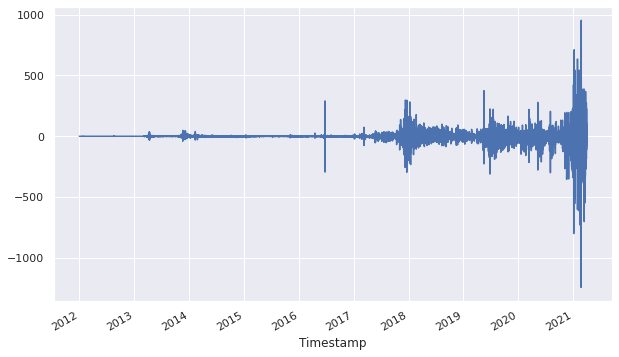

In [ ]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [ ]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

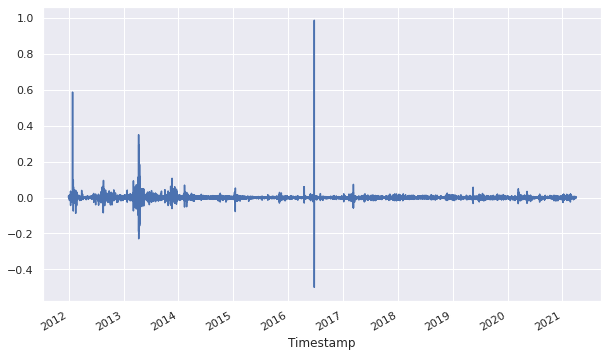

In [ ]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [ ]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:53:00,4.390,4.390,4.39,4.39,0.555046,2.436653,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:54:00,4.390,4.390,4.39,4.39,0.654511,2.873305,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:55:00,4.390,4.390,4.39,4.39,0.753977,3.309958,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:56:00,4.390,4.390,4.39,4.39,0.853442,3.746611,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31 07:57:00,4.390,4.390,4.39,4.39,0.952907,4.183264,4.390000,4.3900,0.0000,Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:51:00,58677.050,58699.900,58660.00,58699.90,2.672676,156832.692130,58680.021260,58684.2125,2.8925,Up,0.000049,0.000234,0.000234,0.000545,-0.000263,-0.000478
2021-03-30 23:52:00,58697.865,58715.565,58679.17,58699.20,1.440329,84520.873706,58691.157958,58697.9500,13.7375,Up,0.000234,0.000234,0.000545,-0.000263,-0.000478,-0.000228
2021-03-30 23:53:00,58718.680,58731.230,58698.34,58698.50,0.207983,12209.055282,58702.294657,58711.6875,13.7375,Up,0.000234,0.000545,-0.000263,-0.000478,-0.000228,0.000372


Cleaned Dataset Display

In [ ]:
df.shape

(4857377, 16)

In [ ]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Timestamp,,,,,,,,,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,NaN,Down,NaN,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,0.0,Down,0.0,0.0,0.0,0.0,0.0,0.0


#**Exploratory Data Analysis**

Zheming's Part

So in this cahart, we use candlestick graph to show the open,close,high and low price of each day throughout the 10 years.we can see that  the price of bitcoin has dropped since 2018, but in the middle of 2020. It has risen rapidly.  Furthermore, we also use the blue line to represent the moving average of 30 perio, the the red line for 50 perio. The shorter the period of the moving average, the faster it can reflect the changes in price trends. For example, the 30 perio moving average is closer to the current price level than the 50-period moving average. The 50-period moving average is more able to reflect the long-term overall price trend.


bitcoin moving average


In [ ]:
df = df.resample("6H").mean()

In [ ]:
import plotly.graph_objects as go
trace1 = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': 'MSFT',
    'showlegend': False
}
# Calculate and define moving average of 30 periods
avg_30 = df.Close.rolling(window=30, min_periods=1).mean()

# Calculate and define moving average of 50 periods
avg_50 = df.Close.rolling(window=50, min_periods=1).mean()

trace2 = {'x': df.index,'y': avg_30,'type': 'scatter','mode': 'lines','line':
          {'width': 1,'color': 'blue'},'name': 'Moving Average of 30 periods'}

trace3 = {'x': df.index,'y': avg_50,'type': 'scatter','mode': 'lines','line':
          {'width': 1,'color': 'red'},'name': 'Moving Average of 50 periods'}

data_trace = [trace1, trace2, trace3]
# Config graph layout
layout = go.Layout({'title': {'text': 'Bitcoin Moving Averages','font': {'size': 15}}})
df = df.resample("24H").mean()
fig = go.Figure(data=data_trace, layout=layout)
fig.show()

In [ ]:
from PIL import Image
with Image.open("/content/a.png") as im:
    im.rotate(45).show()

Populating the interactive namespace from numpy and matplotlib


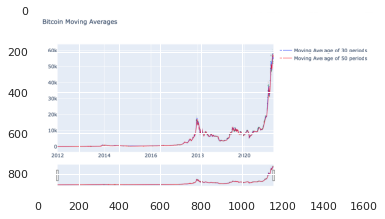

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/a.png')
imgplot = plt.imshow(img)
plt.show()

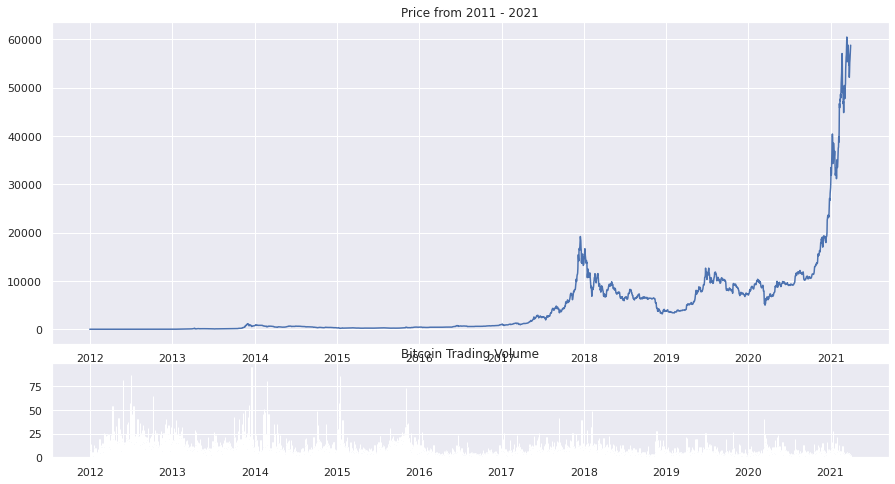

In [ ]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(df.index, df["Price"])
plt.title('Price from 2011 - 2021')

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(df.index, df['Volume_(BTC)'])
plt.title('Bitcoin Trading Volume')

plt.gcf().set_size_inches(15,8)

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

in this graph, we grouped the data by direction,the orange line represents up and the blue line is down. Most of price are below 10000,at around 100 at most.


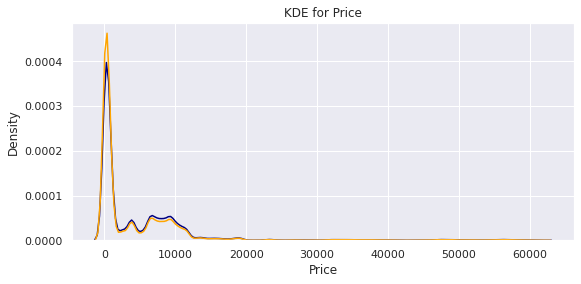

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

Each square shows the correlation between the variables on each axis.The close to 1 the correlation is the more positively correlated they are. As we can see in the graph those which are green, they have a perfect correlation, such as price and open price. For open price and volume(BTC),it has a negative correlation which means if one increase, one will decrease.


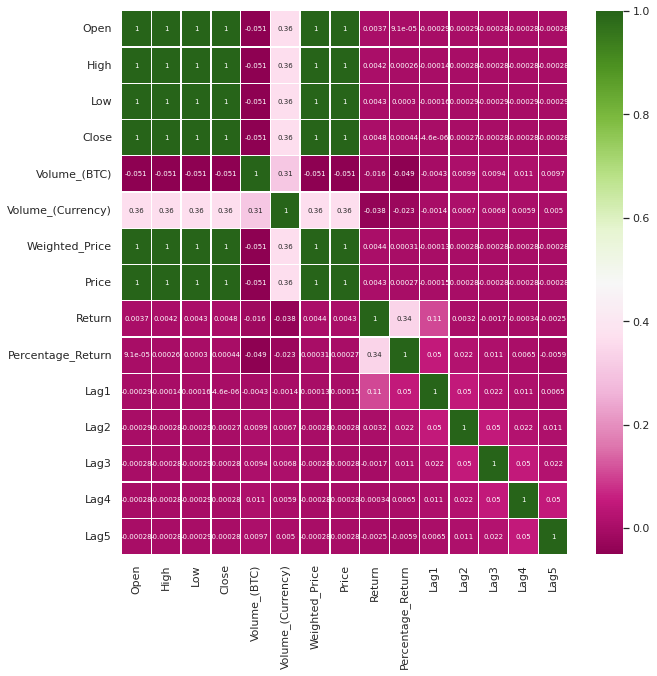

In [ ]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

Next we are gonna talk about the distribution of Opening Price. We used hitagram+KDE, boxplot and violin plot respectively to show the distribution of opening price. I think the box plot tells us more clearly. From the graph we can see the opening price has reached a price close to 17,000. The 17000 should be the maximum, because there are too much data under 10000. So any price beyond 17000 counts as outliers because it happened not much.. In most cases, the opening price will not exceed 7000. But normally, the opening price of bitcoin is around 1000. So we can tell that Bitcoin's opening price fluctuates very much,and most of them are sold at low prices.


In [ ]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


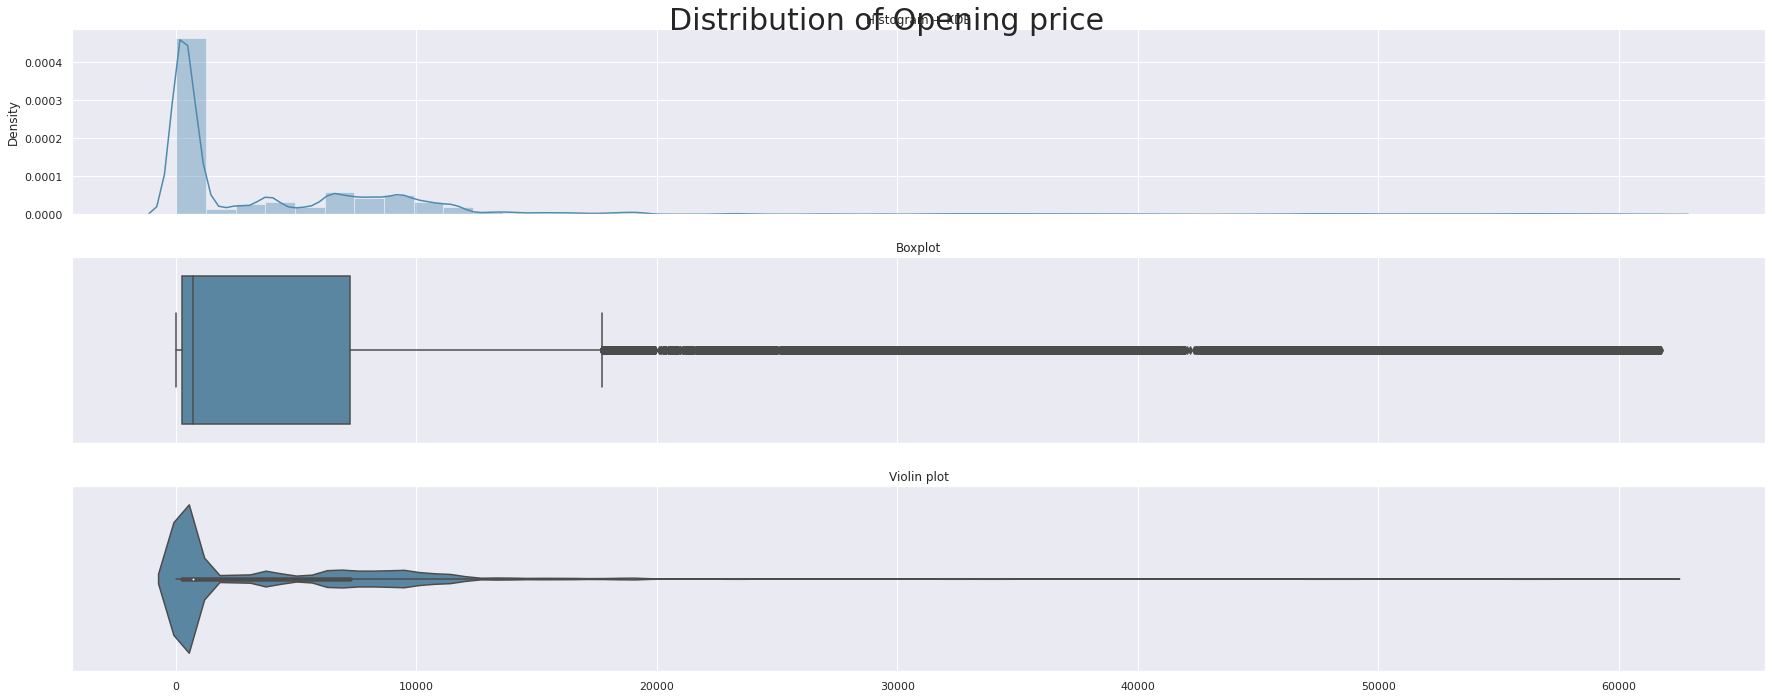

In [ ]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

We can see that there is a positive correlation for minute, hour and daily lag plots. We observe absolutely no correlation for month lag plots.
(resample for 6 hours makes sense?)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

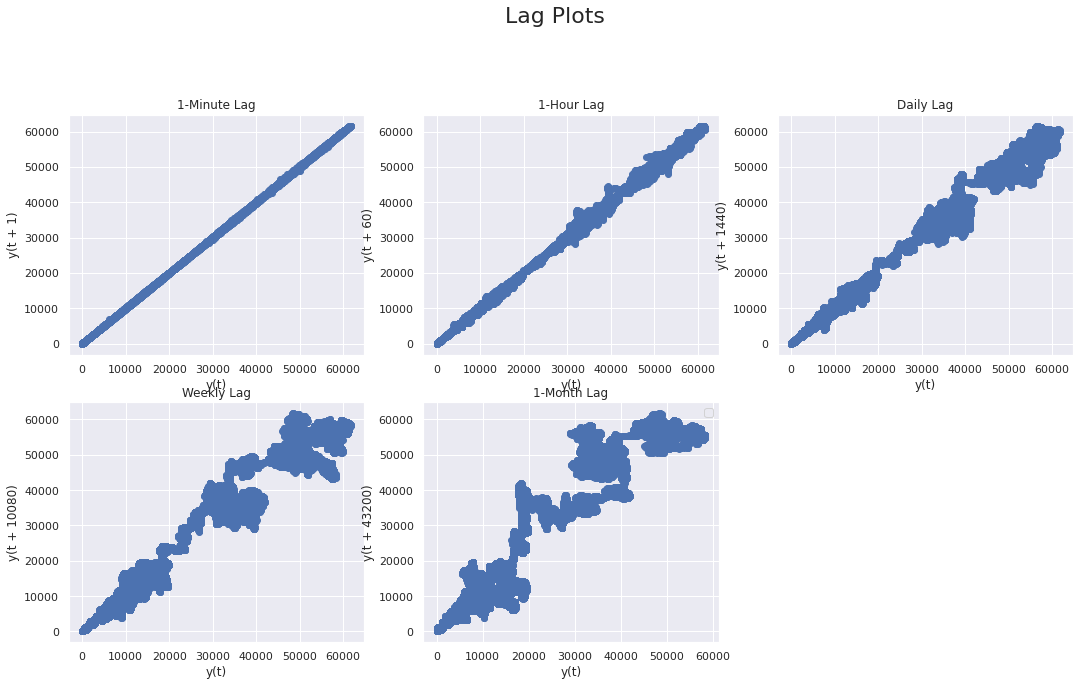

In [ ]:
plt.figure(figsize=(18,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(df['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

# **ARIMA Model**

Geech's part here

# **Simple RNN**

Yihan Jia's part here

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm